In [1]:
from virgo.data.cluster import VirgoCluster
from virgo.data.cleaner import AutoDensityCleaner
from virgo.models.kernel import VirgoKernel
from virgo.models.mixture import VirgoMixture

%load_ext autoreload
%autoreload 2

%matplotlib notebook
# %matplotlib inline

Reading  4537474  particles
Data set 0 - Shape: (491318, 9)
Mean / Std: 279602.354 / 827754.060
Min / Max: -1.000 / 4537471.000
Data set 1 - Shape: (491318, 8)
Mean / Std: 0.000 / 1.000
Min / Max: -1.903 / 5.705


<IPython.core.display.Javascript object>


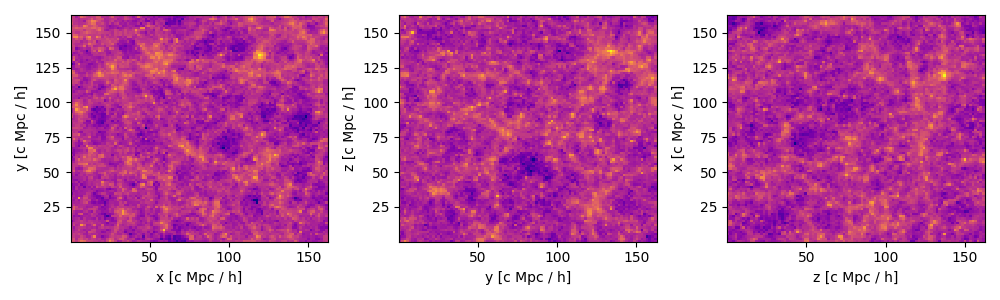

In [2]:
filebase = f"/home/max/Software/virgo/data/box_mhd/MHD_box_snap_019"

virgo_cluster = VirgoCluster(
    file_name=filebase, io_mode=1, cut_mach_dim=-2, n_max_data=1000000, 
)
# virgo_cluster.data = virgo_cluster.data[:, :-1]

virgo_cluster.scale_data()
virgo_cluster.print_datastats()
virgo_cluster.plot_raw_hists(
    bins=100, plot_range=None,
)

In [3]:
virgo_kernel = VirgoKernel(virgo_cluster, k_nystroem=120, pca_comp=5)
virgo_kernel()
virgo_cluster.print_datastats()

Data set 0 - Shape: (491318, 9)
Mean / Std: 279602.354 / 827754.060
Min / Max: -1.000 / 4537471.000
Data set 1 - Shape: (491318, 5)
Mean / Std: -0.000 / 0.278
Min / Max: -0.643 / 0.658


ELBO: 6.541625848089667
Mixture weights [0.05708678 0.02651795 0.02604739 0.02536976 0.01771375 0.02436366
 0.02214073 0.02127234 0.02323567 0.02271602 0.029284   0.02457243
 0.03727673 0.02291779 0.03419302 0.02292262 0.02497109 0.02735951
 0.03155546 0.04245744 0.02645589 0.01643826 0.03214443 0.02474706
 0.03133905 0.04046479 0.03128199 0.01792243 0.03185642 0.02994391
 0.02740581 0.03024673 0.03706045 0.02399483 0.03472381]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34]), array([28107, 20850, 20246, 18294, 18292, 17229, 16793, 15729, 15588,
       15386, 15378, 15343, 14960, 14700, 14420, 13452, 13406, 13109,
       13027, 12902, 12427, 12160, 12052, 12042, 11851, 11720, 11459,
       11344, 11262, 11020, 10673, 10452,  8858,  8739,  8048]))


<IPython.core.display.Javascript object>


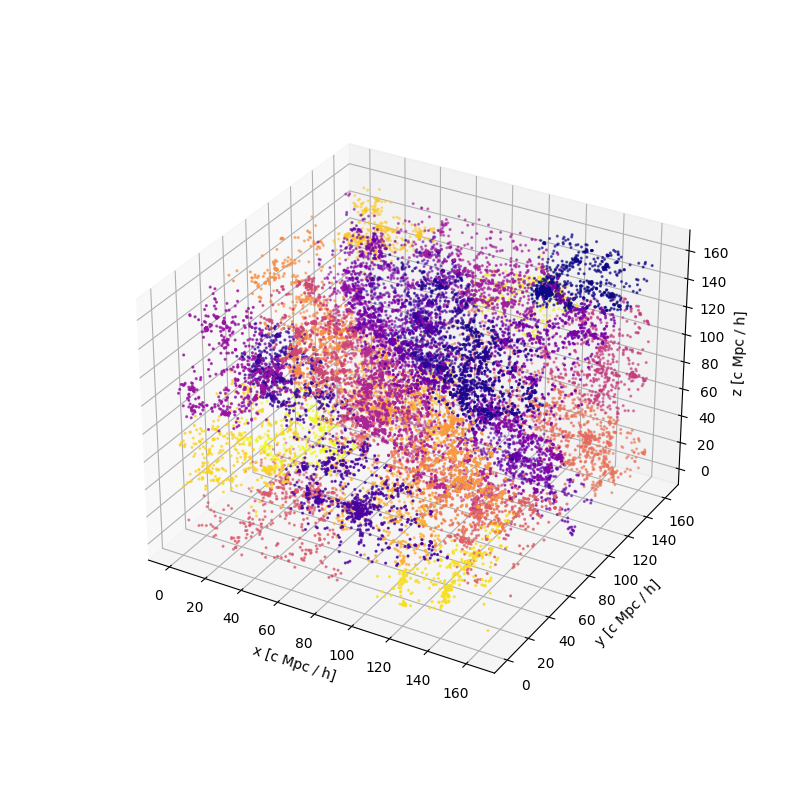

In [4]:
virgo_mixture = VirgoMixture(virgo_cluster, n_comp=35)
elbo = virgo_mixture.fit()

print(f"ELBO: {elbo}")
print(f"Mixture weights {virgo_mixture.model.weights_}")

virgo_mixture.predict(remove_uncertain_labels=False)
labels_removed = virgo_cluster.get_labels(return_counts=True)
print(labels_removed)

# virgo_cluster.plot_cluster(cmap_vmax=4, n_step=25, plot_kernel_space=True, store_gif=False, gif_title="nystroem_separation_kernelspace")
virgo_cluster.plot_cluster(n_step=25, store_gif=False, gif_title="nystroem_separation_kernelspace")

/home/max/Software/virgo/virgo/data/cleaner.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.clusters = np.array(self.clusters)
/home/max/Software/virgo/virgo/data/cleaner.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.labels = np.array(self.labels)


Density cutoff 6.257124880105396e-16
Densities: [3.01702533e-15 2.68316937e-16 4.81160342e-16 4.97783519e-16
 4.45780077e-16 8.40117452e-16 3.03614565e-16 2.35129595e-16
 3.57924037e-16 2.94899154e-16 2.66206796e-16 6.26338827e-16
 4.76835827e-16 4.59489481e-16 3.34004152e-16 3.02479687e-16
 4.07338377e-16 6.85932984e-16 3.88474789e-16 4.43144331e-16
 4.91674550e-16 1.87863801e-16 6.87742978e-16 2.46275778e-16
 1.23265692e-15 1.71181778e-16 7.26039763e-16 1.78809448e-16
 4.05768252e-16 4.79179079e-16 1.20902941e-15 4.31199539e-16
 6.90619537e-16 8.26040112e-16 3.79838530e-16]
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9]), array([353898,  28107,  17229,  15343,  13109,  12052,  11851,  11459,
        10673,   8858,   8739]))


<IPython.core.display.Javascript object>


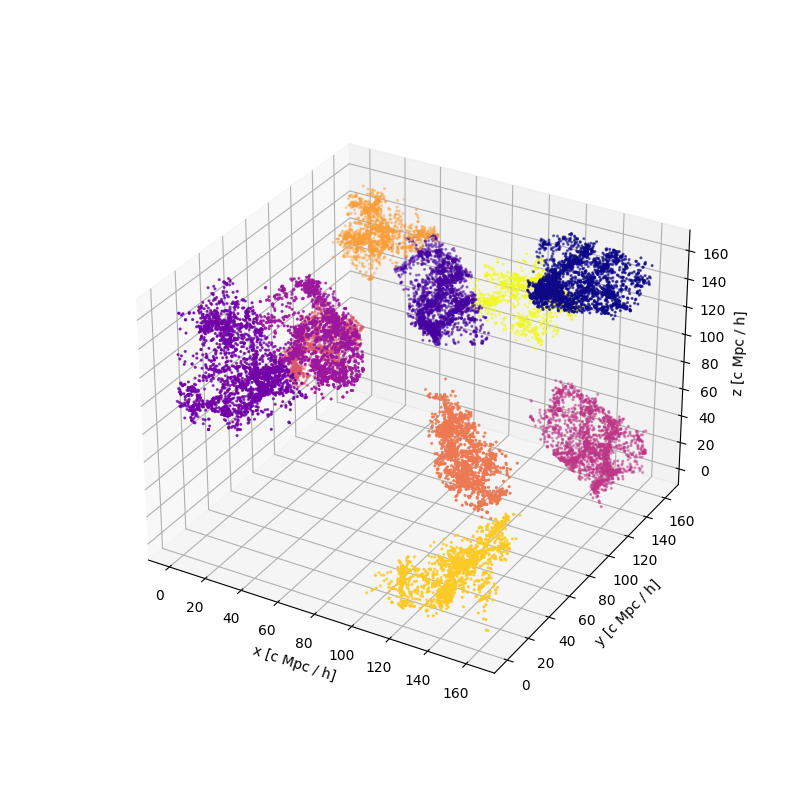

In [5]:
auto_cleaner = AutoDensityCleaner(virgo_cluster, pick_top=10)
auto_cleaner.clean()
print(virgo_cluster.get_labels(return_counts=True))
virgo_cluster.plot_cluster(n_step=5, store_gif=False, gif_title=f"box_gmm35_big10")

Data set 0 - Shape: (10673, 9)
Mean / Std: 291290.717 / 847704.500
Min / Max: -1.000 / 4536403.000
Data set 1 - Shape: (10673, 5)
Mean / Std: 0.000 / 0.280
Min / Max: -0.606 / 0.733
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1960, 1785, 1071, 1005,  898,  889,  878,  844,  686,  657]))


<IPython.core.display.Javascript object>


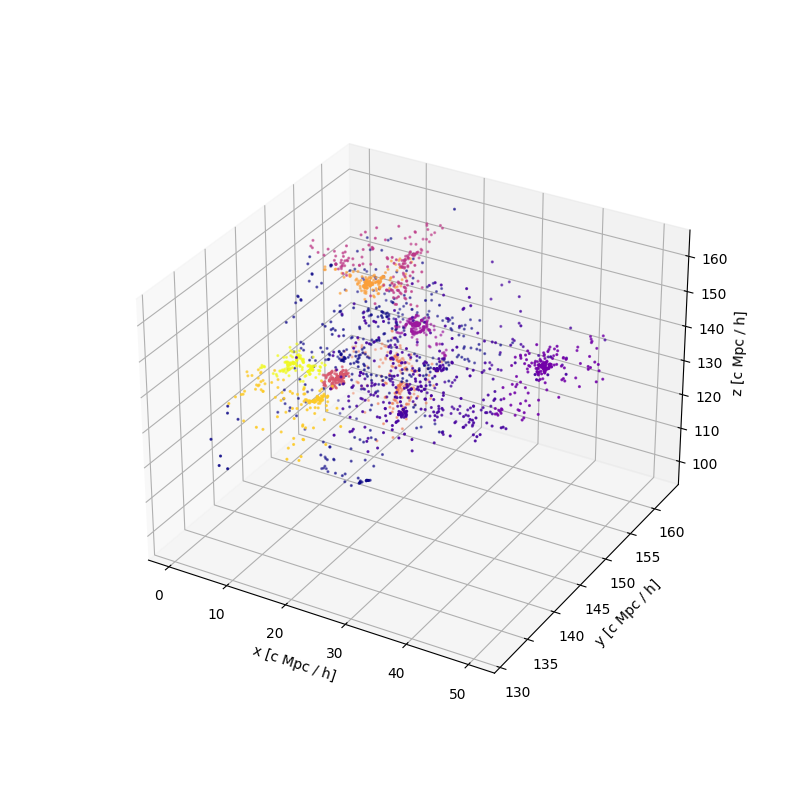

Density cutoff 4.3330676031630573e-13
Densities: [3.85792568e-16 4.22233330e-16 3.65962775e-15 4.50249155e-14
 2.21827847e-15 4.33740501e-13 2.33766450e-15 2.07658618e-14
 2.90287576e-15 3.79927391e-14]
(array([-1,  0]), array([9784,  889]))


/home/max/Software/virgo/virgo/data/cleaner.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.clusters = np.array(self.clusters)
/home/max/Software/virgo/virgo/data/cleaner.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.labels = np.array(self.labels)


<IPython.core.display.Javascript object>


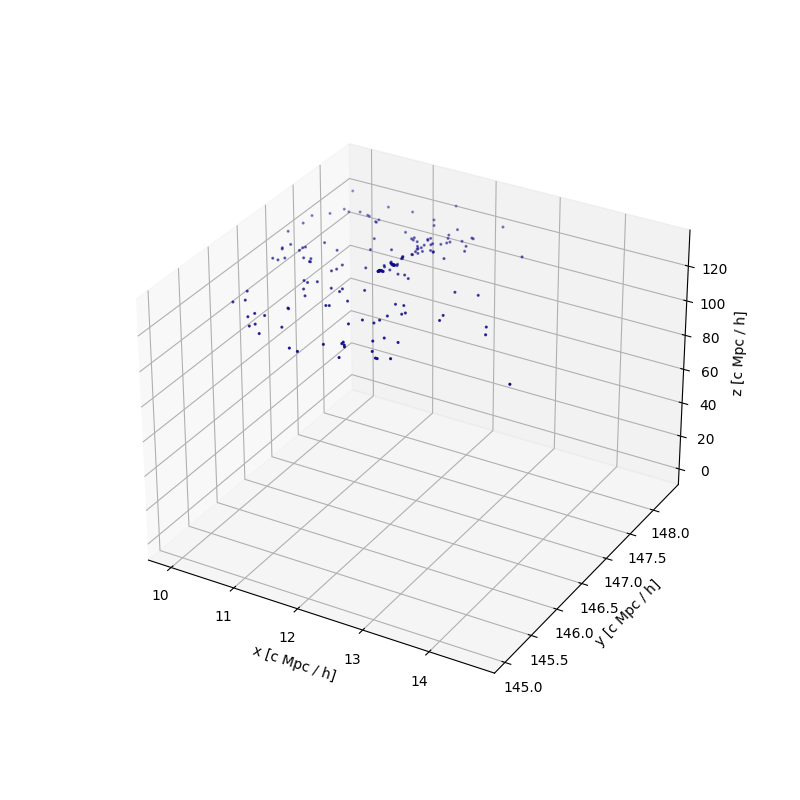

0.27799045421249585 0.1887817089187203 0.5611630175905763 0.03859704611825325
889
Estimated ll: 0.27799
Found  238  groups
[-1  0] [697 192]


/home/max/Software/virgo/virgo/fof/run_fof.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  groups = np.array(pyfof.friends_of_friends(pos, linking_length))
Using non tree accelerated version


<IPython.core.display.Javascript object>


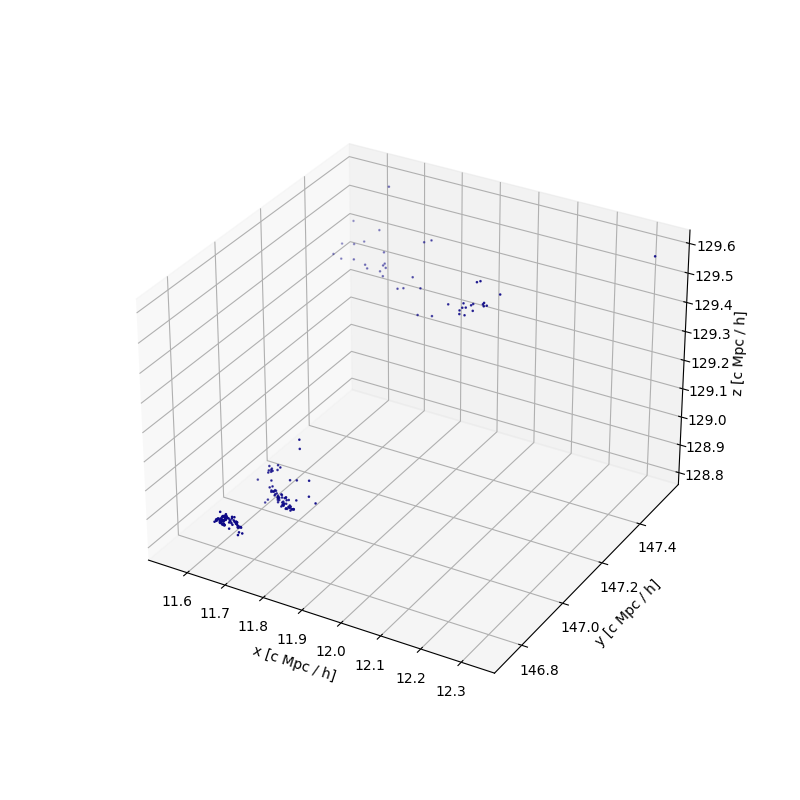

<IPython.core.display.Javascript object>


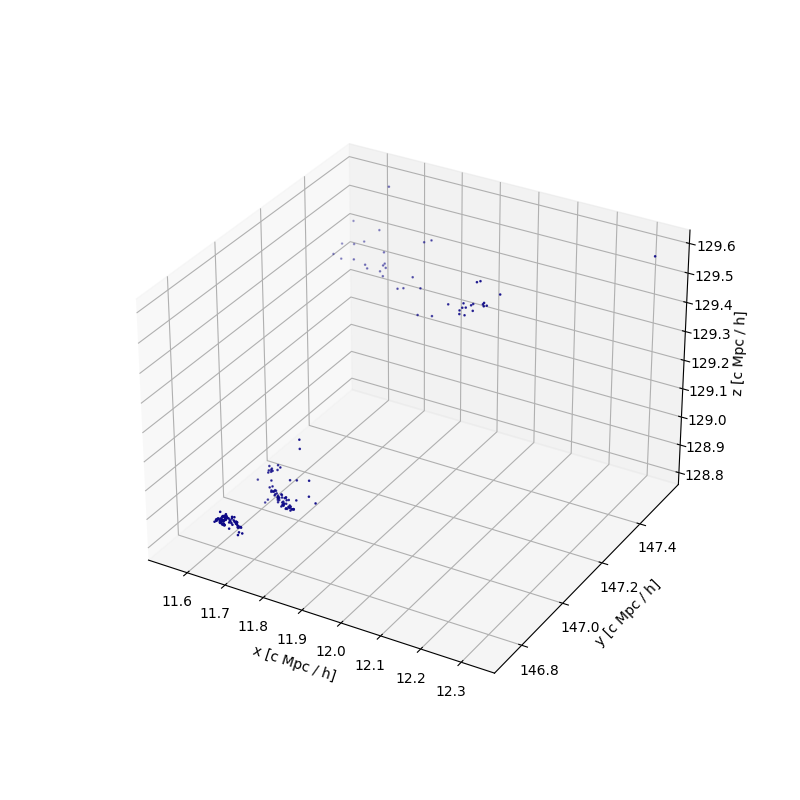

<IPython.core.display.Javascript object>


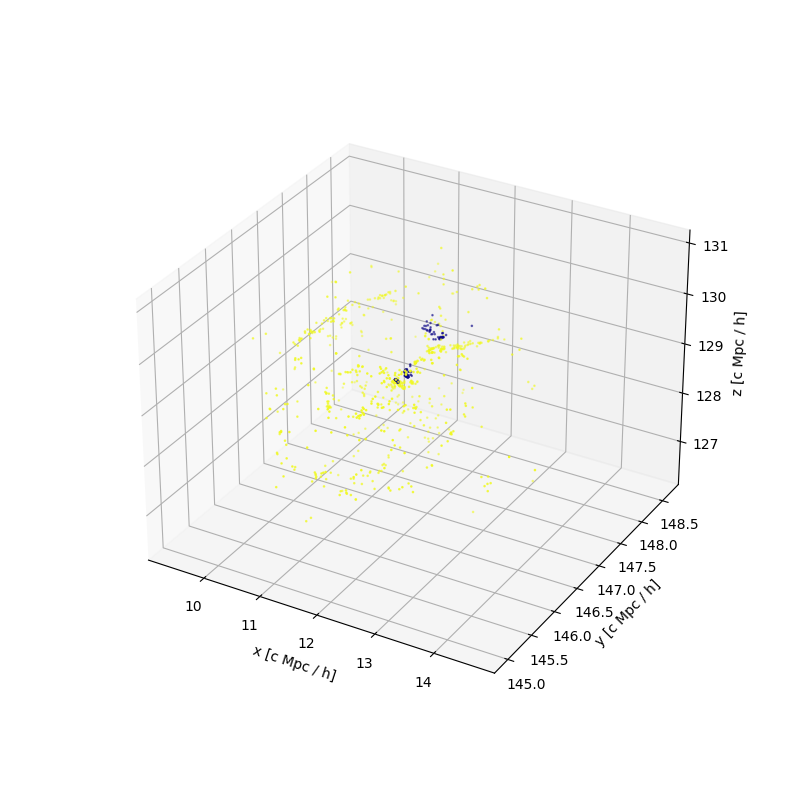

In [14]:
# n_max=1000000, gmm=35, top 10
# k_nystroem=2000, comp=5, k_nystroem=1000
# 0 group  [0.162, 100]
# 1 single [0.16, 100]
# 2 single [0.2, 100]
# 3 two    [0.25, 100]
# 4 two    [0.3, 100]
# 5 single [0.2, 100]
# 6 two    [0.2, 100]
# 7 barely [0.18, 50]
# 8 barely [0.2, 50]
# 9 barely [0.25, 100]
for i in virgo_cluster.get_labels():
    if i in [-1, 0, 1, 2, 3, 4, 5, 6]:
        continue

    vc_2 = VirgoCluster(file_name=None)
    vc_2.data = virgo_cluster.cluster[virgo_cluster.cluster_labels == i]
    vc_2.scale_data()
    
    virgo_kernel_2 = VirgoKernel(vc_2, k_nystroem=2000, pca_comp=5)
    virgo_kernel_2()
    vc_2.print_datastats()
    
    virgo_mixture_2 = VirgoMixture(vc_2, n_comp=10)
    elbo = virgo_mixture_2.fit()
    virgo_mixture_2.predict(remove_uncertain_labels=False)
    labels_removed = vc_2.get_labels(return_counts=True)
    print(labels_removed)
    vc_2.plot_cluster(n_step=5)
    
    auto_cleaner = AutoDensityCleaner(vc_2)
    auto_cleaner.clean()
    print(vc_2.get_labels(return_counts=True))
    vc_2.plot_cluster(n_step=5)
    
    vc_3 = VirgoCluster(file_name=None)
    vc_3.data = vc_2.cluster[vc_2.cluster_labels >=0]
    vc_3.scale_data()
    
    virgo_kernel_3 = VirgoKernel(
        vc_3, k_nystroem=1000, pca_comp=6, spatial_dim=[0, 1, 2, 3, 4, 5]
    )
    virgo_kernel_3(virgo_kernel_3.custom_kernel)
    
#     ll_est = pred_ll(vc_2.scaled_data, i)
#     ll_est = get_avg_nn_dist(vc_2.scaled_data, ind=i)
#     print("LL ", i, ll_est, vc_2.scaled_data.std(), vc_2.scaled_data.var())
    vc_3.run_fof(
#         linking_length=ll_est,
        min_group_size=100,
        use_scaled_data=True,
        n_nn=5,
    )

    labels, counts = vc_3.get_labels(return_counts=True)
    print(labels, counts)
#     vc_3.plot_cluster(n_step=1, plot_kernel_space=True)
    vc_3.plot_cluster(n_step=1, maker_size=3.0)
    vc_3.plot_cluster(n_step=1, maker_size=3.0, store_gif=False, gif_title=f"box_{i}_nn5")

#     break
    labels, counts = vc_3.get_labels(return_counts=True)
    vc_3.cluster_labels[vc_3.cluster_labels < 0] = labels.shape[0] -1 
#     vc_3.plot_cluster(n_step=1)
    vc_3.plot_cluster(n_step=1, maker_size=3.0, store_gif=False, gif_title=f"box_{i}_wnoise_nn5")
#     vc_3.export_cluster(f"vc_box_fitted_set{i}", remove_uncertain=False, remove_evno=True)
    break